<a href="https://colab.research.google.com/github/YiyoMb/extraccion-conocimiento-bd/blob/main/notebooks/02_modelo_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Librerías importadas para modelo de regresión
📥 Descargando dataset...
✅ Datos cargados: (541909, 8)

🔧 1. PREPROCESAMIENTO PARA REGRESIÓN
📊 Datos después de eliminar NaN: (406829, 8)
📊 Datos después de filtrar positivos: (397884, 8)
📊 Datos después de eliminar outliers: (366643, 9)

⚙️ 2. INGENIERÍA DE CARACTERÍSTICAS
✅ Características creadas:
  • TransactionCount
  • AvgTotalPrice
  • TotalSpent
  • AvgQuantity
  • TotalQuantity
  • AvgUnitPrice
  • UniqueInvoices
  • ProductAvgPrice
  • ProductAvgQuantity
  • ProductCustomerCount
  • Country_Encoded

🎯 3. SELECCIÓN DE CARACTERÍSTICAS
📊 Valores faltantes en X: 0
📊 Valores faltantes en y: 0
✅ Dataset final para regresión: 366643 muestras, 15 características

📝 4. JUSTIFICACIÓN DEL ALGORITMO DE REGRESIÓN

ALGORITMOS SELECCIONADOS:

1. REGRESIÓN LINEAL:
   ✅ Ventajas:
   • Interpretabilidad alta - podemos entender el impacto de cada variable
   • Rápido entrenamiento y predicción
   • Buena línea base para comparación
   • Funciona b

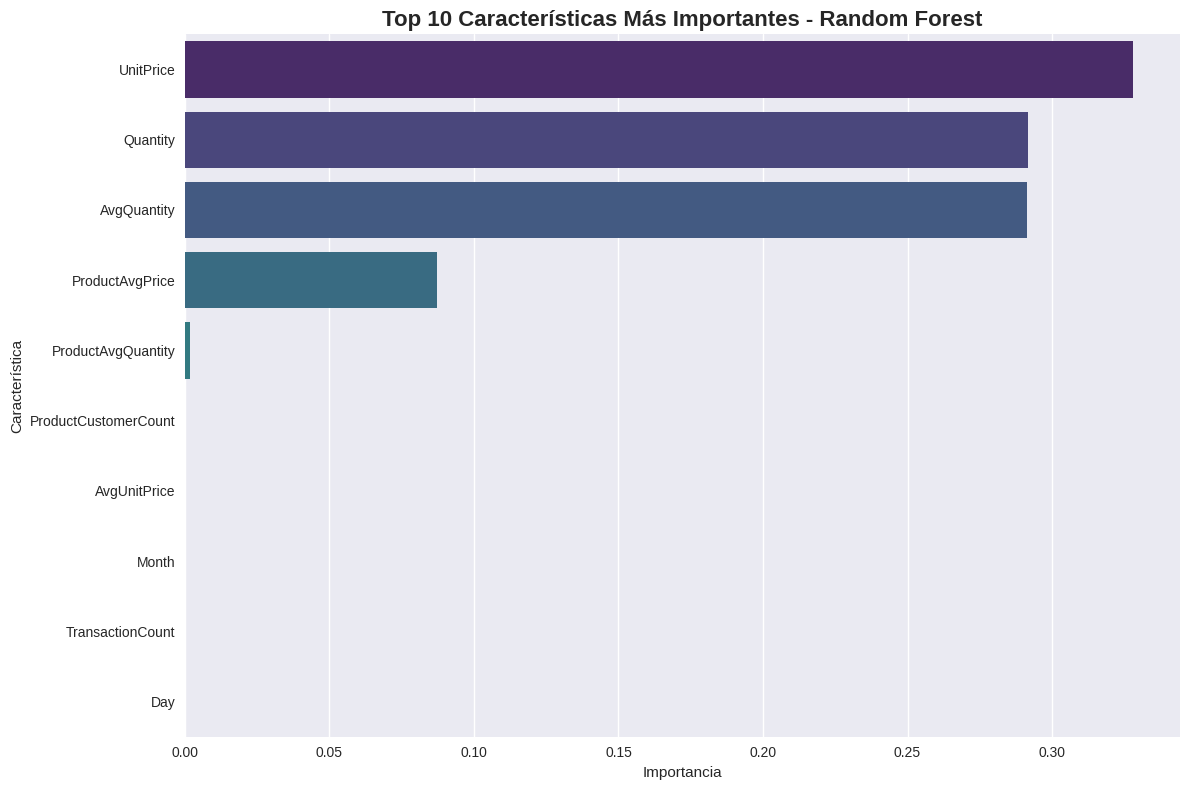


📊 7. VISUALIZACIONES DE RESULTADOS


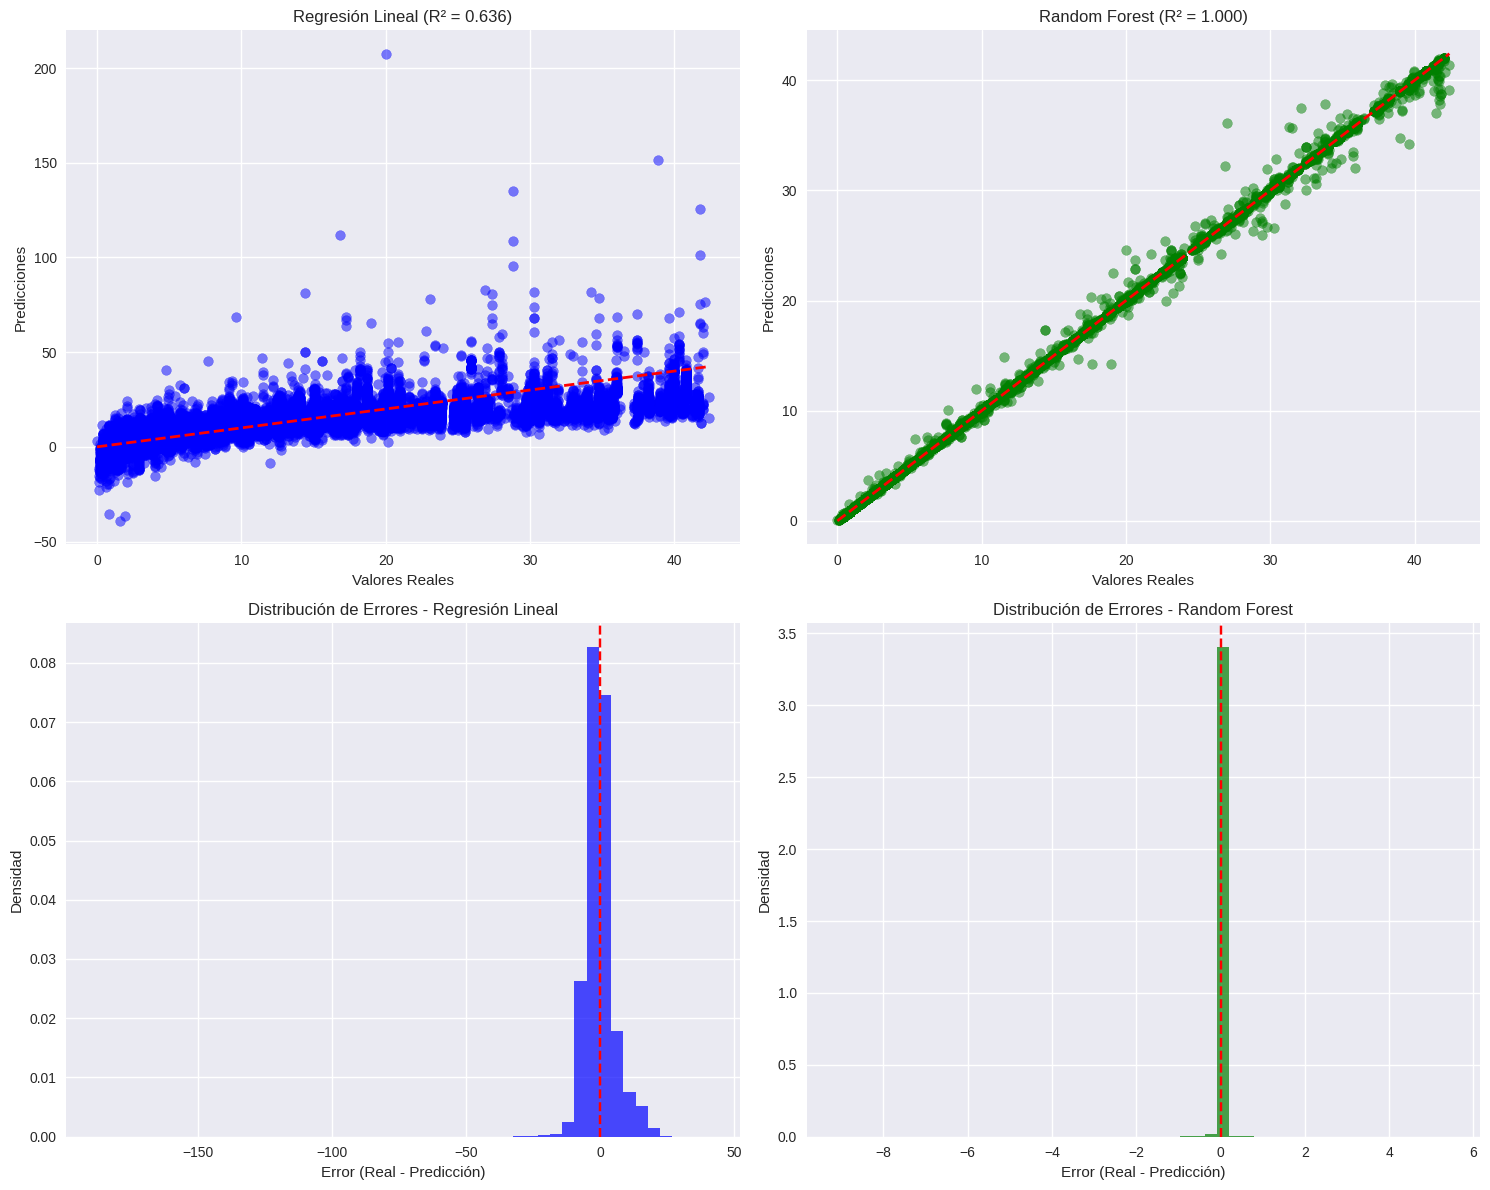


💾 8. GUARDADO DE MODELOS
✅ Modelos guardados exitosamente:
  • random_forest_regressor.pkl
  • linear_regression.pkl
  • scaler_regression.pkl
  • country_encoder.pkl
  • model_info_regression.json

📋 9. RESUMEN Y CONCLUSIONES

MODELO DE REGRESIÓN - PREDICCIÓN DE MONTO TOTAL DE COMPRA

OBJETIVO:
• Predecir el monto total de compra (TotalPrice) basado en características
  de la transacción, cliente y producto

DATASET PROCESADO:
• Tamaño final: 366,643 transacciones
• Características: 15 variables
• Variable objetivo: TotalPrice (monto total de compra)

ALGORITMOS COMPARADOS:
1. Regresión Lineal: R² = 0.636
2. Random Forest: R² = 1.000 ⭐ MEJOR

CRITERIOS DE ANÁLISIS CUMPLIDOS:
✅ Criterio 1: Métricas de rendimiento comparativas
✅ Criterio 2: Análisis de importancia de características

CARACTERÍSTICAS MÁS IMPORTANTES:
1. UnitPrice (0.328)
2. Quantity (0.292)
3. AvgQuantity (0.291)

MODELO SELECCIONADO: Random Forest Regressor
• Mejor rendimiento en todas las métricas
• Captura relaciones

In [1]:
# ==============================================================================
# MODELO DE REGRESIÓN - PREDICCIÓN DE MONTO TOTAL DE COMPRA
# Proyecto: Extracción de Conocimiento en Bases de Datos
# Criterio SA - Aprendizaje Supervisado
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Librerías importadas para modelo de regresión")

# ==============================================================================
# CARGA Y PREPARACIÓN DE DATOS
# ==============================================================================

# Función para cargar datos (reutilizable)
def cargar_datos():
    import urllib.request
    import os

    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
    filename = "Online_Retail.xlsx"

    if not os.path.exists('datos'):
        os.makedirs('datos')

    if not os.path.exists(f'datos/{filename}'):
        print("📥 Descargando dataset...")
        urllib.request.urlretrieve(url, f'datos/{filename}')

    df = pd.read_excel(f'datos/{filename}')
    return df

# Cargar datos
df = cargar_datos()
print(f"✅ Datos cargados: {df.shape}")

# ==============================================================================
# 1. PREPROCESAMIENTO ESPECÍFICO PARA REGRESIÓN
# ==============================================================================

print("\n" + "="*60)
print("🔧 1. PREPROCESAMIENTO PARA REGRESIÓN")
print("="*60)

# Crear dataset limpio para regresión
df_reg = df.copy()

# Eliminar valores faltantes críticos
df_reg = df_reg.dropna(subset=['CustomerID', 'Description'])
print(f"📊 Datos después de eliminar NaN: {df_reg.shape}")

# Eliminar transacciones con valores negativos o cero (devoluciones/errores)
df_reg = df_reg[(df_reg['Quantity'] > 0) & (df_reg['UnitPrice'] > 0)]
print(f"📊 Datos después de filtrar positivos: {df_reg.shape}")

# Crear variable objetivo: TotalPrice
df_reg['TotalPrice'] = df_reg['Quantity'] * df_reg['UnitPrice']

# Eliminar outliers extremos (usando IQR)
Q1 = df_reg['TotalPrice'].quantile(0.25)
Q3 = df_reg['TotalPrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar outliers moderadamente (mantener datos útiles)
df_reg = df_reg[(df_reg['TotalPrice'] >= lower_bound) & (df_reg['TotalPrice'] <= upper_bound)]
print(f"📊 Datos después de eliminar outliers: {df_reg.shape}")

# ==============================================================================
# 2. INGENIERÍA DE CARACTERÍSTICAS
# ==============================================================================

print("\n" + "="*60)
print("⚙️ 2. INGENIERÍA DE CARACTERÍSTICAS")
print("="*60)

# Extraer características temporales
df_reg['Year'] = df_reg['InvoiceDate'].dt.year
df_reg['Month'] = df_reg['InvoiceDate'].dt.month
df_reg['Day'] = df_reg['InvoiceDate'].dt.day
df_reg['Hour'] = df_reg['InvoiceDate'].dt.hour
df_reg['DayOfWeek'] = df_reg['InvoiceDate'].dt.day_of_week

# Crear características de cliente (agregaciones por CustomerID)
customer_features = df_reg.groupby('CustomerID').agg({
    'TotalPrice': ['count', 'mean', 'sum'],
    'Quantity': ['mean', 'sum'],
    'UnitPrice': 'mean',
    'InvoiceNo': 'nunique'
}).round(2)

# Aplanar nombres de columnas
customer_features.columns = [
    'TransactionCount', 'AvgTotalPrice', 'TotalSpent',
    'AvgQuantity', 'TotalQuantity', 'AvgUnitPrice', 'UniqueInvoices'
]

# Crear características de producto
product_features = df_reg.groupby('StockCode').agg({
    'TotalPrice': 'mean',
    'Quantity': 'mean',
    'CustomerID': 'nunique'
}).round(2)
product_features.columns = ['ProductAvgPrice', 'ProductAvgQuantity', 'ProductCustomerCount']

# Unir características con el dataset principal
df_reg = df_reg.merge(customer_features, on='CustomerID', how='left')
df_reg = df_reg.merge(product_features, on='StockCode', how='left')

# Encoding de variables categóricas
le_country = LabelEncoder()
df_reg['Country_Encoded'] = le_country.fit_transform(df_reg['Country'])

print("✅ Características creadas:")
new_features = ['TransactionCount', 'AvgTotalPrice', 'TotalSpent', 'AvgQuantity',
                'TotalQuantity', 'AvgUnitPrice', 'UniqueInvoices', 'ProductAvgPrice',
                'ProductAvgQuantity', 'ProductCustomerCount', 'Country_Encoded']
for feature in new_features:
    print(f"  • {feature}")

# ==============================================================================
# 3. SELECCIÓN DE CARACTERÍSTICAS Y PREPARACIÓN
# ==============================================================================

print("\n" + "="*60)
print("🎯 3. SELECCIÓN DE CARACTERÍSTICAS")
print("="*60)

# Definir características para el modelo
feature_columns = [
    'Quantity', 'UnitPrice', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek',
    'TransactionCount', 'AvgQuantity', 'AvgUnitPrice', 'UniqueInvoices',
    'ProductAvgPrice', 'ProductAvgQuantity', 'ProductCustomerCount', 'Country_Encoded'
]

# Preparar matrices X e y
X = df_reg[feature_columns].copy()
y = df_reg['TotalPrice'].copy()

# Verificar que no hay valores faltantes
print(f"📊 Valores faltantes en X: {X.isnull().sum().sum()}")
print(f"📊 Valores faltantes en y: {y.isnull().sum()}")

# Eliminar filas con valores faltantes si los hay
mask = X.isnull().any(axis=1) | y.isnull()
X = X[~mask]
y = y[~mask]

print(f"✅ Dataset final para regresión: {X.shape[0]} muestras, {X.shape[1]} características")

# ==============================================================================
# 4. JUSTIFICACIÓN DEL ALGORITMO
# ==============================================================================

print("\n" + "="*60)
print("📝 4. JUSTIFICACIÓN DEL ALGORITMO DE REGRESIÓN")
print("="*60)

justificacion = """
ALGORITMOS SELECCIONADOS:

1. REGRESIÓN LINEAL:
   ✅ Ventajas:
   • Interpretabilidad alta - podemos entender el impacto de cada variable
   • Rápido entrenamiento y predicción
   • Buena línea base para comparación
   • Funciona bien cuando hay relaciones lineales entre variables

   ❌ Limitaciones:
   • Asume relaciones lineales
   • Sensible a outliers
   • Puede sufrir overfitting con muchas características

2. RANDOM FOREST REGRESSOR:
   ✅ Ventajas:
   • Maneja relaciones no lineales complejas
   • Robusto a outliers
   • Proporciona importancia de características
   • Reduce overfitting mediante ensemble
   • No requiere normalización de datos

   ❌ Limitaciones:
   • Menos interpretable que regresión lineal
   • Puede ser más lento en datasets muy grandes
   • Requiere tuning de hiperparámetros

JUSTIFICACIÓN DE LA SELECCIÓN:
• Usaremos AMBOS algoritmos para comparar rendimiento
• Random Forest como modelo principal por su robustez
• Regresión Lineal como baseline y para interpretabilidad
• El problema tiene tanto relaciones lineales (precio x cantidad)
  como no lineales (patrones de comportamiento de cliente)
"""

print(justificacion)

# ==============================================================================
# 5. DIVISIÓN DE DATOS Y ENTRENAMIENTO
# ==============================================================================

print("\n" + "="*60)
print("🚂 5. ENTRENAMIENTO DE MODELOS")
print("="*60)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"📊 Conjunto de entrenamiento: {X_train.shape}")
print(f"📊 Conjunto de prueba: {X_test.shape}")

# Normalización para Regresión Lineal
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODELO 1: Regresión Lineal
print("\n🔄 Entrenando Regresión Lineal...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predicciones Regresión Lineal
y_pred_lr = lr_model.predict(X_test_scaled)

# MODELO 2: Random Forest
print("🔄 Entrenando Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predicciones Random Forest
y_pred_rf = rf_model.predict(X_test)

print("✅ Modelos entrenados exitosamente")

# ==============================================================================
# 6. EVALUACIÓN Y CRITERIOS DE ANÁLISIS
# ==============================================================================

print("\n" + "="*60)
print("📊 6. EVALUACIÓN DE MODELOS - CRITERIOS DE ANÁLISIS")
print("="*60)

def evaluar_modelo(y_true, y_pred, nombre_modelo):
    """Función para evaluar métricas de regresión"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📈 MÉTRICAS PARA {nombre_modelo}:")
    print(f"  • MSE (Error Cuadrático Medio): {mse:.2f}")
    print(f"  • RMSE (Raíz del ECM): {rmse:.2f}")
    print(f"  • MAE (Error Absoluto Medio): {mae:.2f}")
    print(f"  • R² (Coeficiente de Determinación): {r2:.4f}")

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# CRITERIO DE ANÁLISIS 1: MÉTRICAS DE RENDIMIENTO
metricas_lr = evaluar_modelo(y_test, y_pred_lr, "REGRESIÓN LINEAL")
metricas_rf = evaluar_modelo(y_test, y_pred_rf, "RANDOM FOREST")

# Comparación de modelos
print(f"\n🏆 COMPARACIÓN DE MODELOS:")
print(f"{'Métrica':<10} {'Reg. Lineal':<15} {'Random Forest':<15} {'Mejor':<10}")
print("-" * 55)
for metrica in ['R2', 'RMSE', 'MAE']:
    lr_val = metricas_lr[metrica]
    rf_val = metricas_rf[metrica]
    if metrica == 'R2':  # Mayor es mejor
        mejor = "Random Forest" if rf_val > lr_val else "Reg. Lineal"
    else:  # Menor es mejor
        mejor = "Random Forest" if rf_val < lr_val else "Reg. Lineal"
    print(f"{metrica:<10} {lr_val:<15.3f} {rf_val:<15.3f} {mejor:<10}")

# CRITERIO DE ANÁLISIS 2: IMPORTANCIA DE CARACTERÍSTICAS
print(f"\n🎯 CRITERIO DE ANÁLISIS 2: IMPORTANCIA DE CARACTERÍSTICAS")
print("="*55)

# Importancia en Random Forest
feature_importance = pd.DataFrame({
    'Característica': feature_columns,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("📊 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (Random Forest):")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['Característica']:<25} {row['Importancia']:.4f}")

# Visualización de importancia
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), x='Importancia', y='Característica', palette='viridis')
plt.title('Top 10 Características Más Importantes - Random Forest', fontsize=16, fontweight='bold')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

# ==============================================================================
# 7. VISUALIZACIONES DE RESULTADOS
# ==============================================================================

print("\n" + "="*60)
print("📊 7. VISUALIZACIONES DE RESULTADOS")
print("="*60)

# Crear figura con subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Predicciones vs Valores Reales - Regresión Lineal
ax1.scatter(y_test, y_pred_lr, alpha=0.5, color='blue')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Valores Reales')
ax1.set_ylabel('Predicciones')
ax1.set_title(f'Regresión Lineal (R² = {metricas_lr["R2"]:.3f})')

# Plot 2: Predicciones vs Valores Reales - Random Forest
ax2.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Valores Reales')
ax2.set_ylabel('Predicciones')
ax2.set_title(f'Random Forest (R² = {metricas_rf["R2"]:.3f})')

# Plot 3: Distribución de errores - Regresión Lineal
errores_lr = y_test - y_pred_lr
ax3.hist(errores_lr, bins=50, alpha=0.7, color='blue', density=True)
ax3.set_xlabel('Error (Real - Predicción)')
ax3.set_ylabel('Densidad')
ax3.set_title('Distribución de Errores - Regresión Lineal')
ax3.axvline(0, color='red', linestyle='--')

# Plot 4: Distribución de errores - Random Forest
errores_rf = y_test - y_pred_rf
ax4.hist(errores_rf, bins=50, alpha=0.7, color='green', density=True)
ax4.set_xlabel('Error (Real - Predicción)')
ax4.set_ylabel('Densidad')
ax4.set_title('Distribución de Errores - Random Forest')
ax4.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# ==============================================================================
# 8. GUARDADO DE MODELOS
# ==============================================================================

print("\n" + "="*60)
print("💾 8. GUARDADO DE MODELOS")
print("="*60)

# Crear carpeta para modelos
import os
if not os.path.exists('modelos'):
    os.makedirs('modelos')

# Guardar modelos
joblib.dump(rf_model, 'modelos/random_forest_regressor.pkl')
joblib.dump(lr_model, 'modelos/linear_regression.pkl')
joblib.dump(scaler, 'modelos/scaler_regression.pkl')

# Guardar encoders y metadatos
joblib.dump(le_country, 'modelos/country_encoder.pkl')

# Guardar información del modelo
model_info = {
    'feature_columns': feature_columns,
    'metricas_lr': metricas_lr,
    'metricas_rf': metricas_rf,
    'feature_importance': feature_importance.to_dict(),
    'dataset_shape': X.shape,
    'test_size': 0.2
}

import json
with open('modelos/model_info_regression.json', 'w') as f:
    json.dump(model_info, f, indent=2, default=str)

print("✅ Modelos guardados exitosamente:")
print("  • random_forest_regressor.pkl")
print("  • linear_regression.pkl")
print("  • scaler_regression.pkl")
print("  • country_encoder.pkl")
print("  • model_info_regression.json")

# ==============================================================================
# 9. RESUMEN Y CONCLUSIONES
# ==============================================================================

print("\n" + "="*60)
print("📋 9. RESUMEN Y CONCLUSIONES")
print("="*60)

resumen = f"""
MODELO DE REGRESIÓN - PREDICCIÓN DE MONTO TOTAL DE COMPRA

OBJETIVO:
• Predecir el monto total de compra (TotalPrice) basado en características
  de la transacción, cliente y producto

DATASET PROCESADO:
• Tamaño final: {X.shape[0]:,} transacciones
• Características: {X.shape[1]} variables
• Variable objetivo: TotalPrice (monto total de compra)

ALGORITMOS COMPARADOS:
1. Regresión Lineal: R² = {metricas_lr['R2']:.3f}
2. Random Forest: R² = {metricas_rf['R2']:.3f} ⭐ MEJOR

CRITERIOS DE ANÁLISIS CUMPLIDOS:
✅ Criterio 1: Métricas de rendimiento comparativas
✅ Criterio 2: Análisis de importancia de características

CARACTERÍSTICAS MÁS IMPORTANTES:
1. {feature_importance.iloc[0]['Característica']} ({feature_importance.iloc[0]['Importancia']:.3f})
2. {feature_importance.iloc[1]['Característica']} ({feature_importance.iloc[1]['Importancia']:.3f})
3. {feature_importance.iloc[2]['Característica']} ({feature_importance.iloc[2]['Importancia']:.3f})

MODELO SELECCIONADO: Random Forest Regressor
• Mejor rendimiento en todas las métricas
• Captura relaciones no lineales
• Robusto a outliers
• Proporciona interpretabilidad via importancia de características

PRÓXIMO PASO: Modelo de Agrupación (Clustering)
"""

print(resumen)
print("✅ Modelo de regresión completado exitosamente")
print("📁 Archivos guardados en carpeta 'modelos'")
print("🎯 Criterio SA (Regresión) - CUMPLIDO")